In [5]:
import io
import numpy as np
from pymrmr import mRMR
import pandas as pd
import requests as rq

#for decoder training
from riglib.bmi import accumulator, assist, bmi, clda, extractor, feedback_controllers, goal_calculators, robot_arms, sim_neurons, kfdecoder, ppfdecoder, state_space_models, train
from riglib.bmi.sim_neurons import KalmanEncoder

# load features

the following code has been copied and pasted from gen_test_data of decoder_training.ipynb
the idea is to generate cosine tuned spikes from states. 

and use mrmr select useful states.


## generate states

In [1]:
from riglib.bmi.state_space_models import StateSpaceEndptVel2D
ssm = StateSpaceEndptVel2D()


n_samples = 2000

#W = np.identity(N_STATES)
#W = np.zeros((N_STATES,N_STATES))
A, _, W = ssm.get_ssm_matrices()

mean = np.zeros(A.shape[0])
mean[-1] = 1
state_samples = np.random.multivariate_normal(mean, W, n_samples)

state_samples
state_samples.shape

(2000, 7)

## set up encoder

In [2]:
N_NEURONS = 3000
N_STATES = 7  # 3 positions and 3 velocities and an offset




# build the observation matrix
sim_C = np.zeros((N_NEURONS, N_STATES))
# control x positive directions
sim_C[0, :] = np.array([0, 0, 0, 1, 0, 0, 0])
sim_C[1, :] = np.array([0, 0, 0, -1, 0, 0, 0])


# control z positive directions
sim_C[2, :] = np.array([0, 0, 0, 0, 0, 1, 0])
sim_C[3, :] = np.array([0, 0, 0, 0, 0, -1, 0])



## train the decoder from the simulated data  

In [3]:
from riglib.bmi.sim_neurons import GenericCosEnc#CLDASimCosEnc

print('SimCosineTunedEnc SSM:', ssm)
encoder = GenericCosEnc(sim_C, 
                         ssm, 
                         return_ts=True, 
                         DT=0.1, 
                         call_ds_rate=6)
encoder.call_ds_rate = 1
sim_C.shape

SimCosineTunedEnc SSM: State space: ['hand_px', 'hand_py', 'hand_pz', 'hand_vx', 'hand_vy', 'hand_vz', 'offset']


(3000, 7)

## gen simulated spikes

In [6]:
n_units = sim_C.shape[0]
spike_counts = np.zeros([n_units, n_samples])

for k in range(n_samples):
    spike_counts[:,k] = np.array(encoder(state_samples[k],
                                              mode='counts')).ravel()

kin = state_samples.T
trained_decoder = train.train_KFDecoder_abstract(ssm, 
                                              kin, 
                                              spike_counts, 
                                              encoder.get_units(), 
                                              0.1, 
                                              zscore=False)
trained_decoder.filt.C

{}
end of kwargs
('zscore value: ', False, <class 'bool'>)
no init_zscore


matrix([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.00249975,  0.10942584],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.00107835,  0.08568598],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.04673258,  0.09708481],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

## Cast features into feature selection problem
by this I want to transform the variables

### states are targets

In [7]:
print(kin.shape)
#want an easy case, just x y, on the screeen
kin_x_vel = kin[3,:]

kin_x_vel = np.expand_dims(kin_x_vel, axis = 1).T
kin_x_vel.shape

y = kin.T
print(y.shape)

X = spike_counts.T
print(X.shape)

(7, 2000)
(2000, 7)
(2000, 3000)


# feature selection using joint covariance matrix

[0. 0. 0. ... 0. 0. 0.]


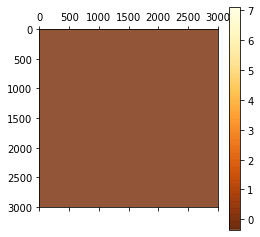

In [14]:
feat_target = np.concatenate((X, y), axis = 1)

cov = np.cov(feat_target.T)
cov.shape

import matplotlib.pyplot as plt
import seaborn as sns

plt.matshow(cov, alpha=0.8, cmap='YlOrBr_r')
plt.colorbar()

#sns.heatmap(cov)
print(cov[7,:])


we need to normalize the calculation.



In [15]:
print(cov.diagonal())

[0.13838019 0.09064532 0.11785668 ... 7.02193208 7.12099758 0.        ]


## look at the regularized covarience matrix

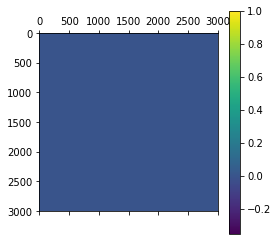

In [17]:

var_mat  = cov.diagonal()

cov_norm = np.zeros(cov.shape)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        if var_mat[i] != 0 and (var_mat[j] != 0):
            cov_norm[i,j] = cov[i,j] / np.sqrt(var_mat[i])/np.sqrt(var_mat[j])

            
        

plt.matshow(cov_norm)
plt.colorbar()
            
plt.show()

#print(cov_norm.diagonal())

## just look at the firing-state cov

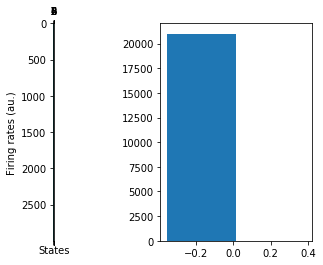

In [26]:
N_BINS = 2


fire_state_cov = cov_norm[:3000, 3000:]


axe_0 = plt.subplot(1,2,1)
axe_0.matshow(fire_state_cov)
axe_0.set_ylabel('Firing rates (au.)')
axe_0.set_xlabel('States')
#axe_0.set_colorbar()

axe_1 = plt.subplot(1,2,2)
axe_1.hist(fire_state_cov.flatten(),bins= N_BINS)  # arguments are passed to np.histogram
plt.show()

# select promising features.



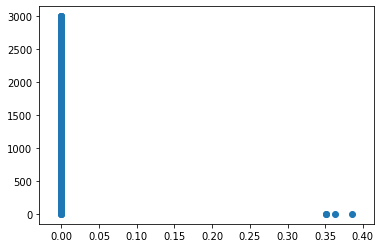

In [33]:
max_cov = np.max(np.abs(fire_state_cov), axis=1)

plt.scatter(max_cov, range(3000))
# fire_state_cov.shape

In [41]:
N_SELECT = 10

np.argsort(max_cov)[-N_SELECT:]


array([1002, 1003, 1004, 1005, 1006,  997,    1,    3,    2,    0])